## Flights with a focus on India

Our team of elite Data Scientists is focusing on analyzing Commercial Airflight data within India, utilizing datasets that encompass airline operations, airplane models, airport locations, and flight routes. This initiative aims to enhance the understanding and efficiency of India's aviation sector through Python tools designed to map airports across the country, analyze flight distances and routes, and compare the usage of different airplane models. By concentrating on the wealth of data available, we are positioned to uncover insights into operational patterns, connectivity, and fleet utilization across India's diverse and rapidly growing aviation market. This comprehensive analysis is geared towards identifying opportunities for optimization and growth, shedding light on the complexities of air travel in India without a specific emphasis on sustainability. With the aim of contributing to a more informed and efficient aviation industry, our work seeks to pave the way for advancements in air travel management and strategic planning in India.

In [1]:
from Functions.air_traffic_data import AirTrafficData 

In [2]:
india_env = AirTrafficData()

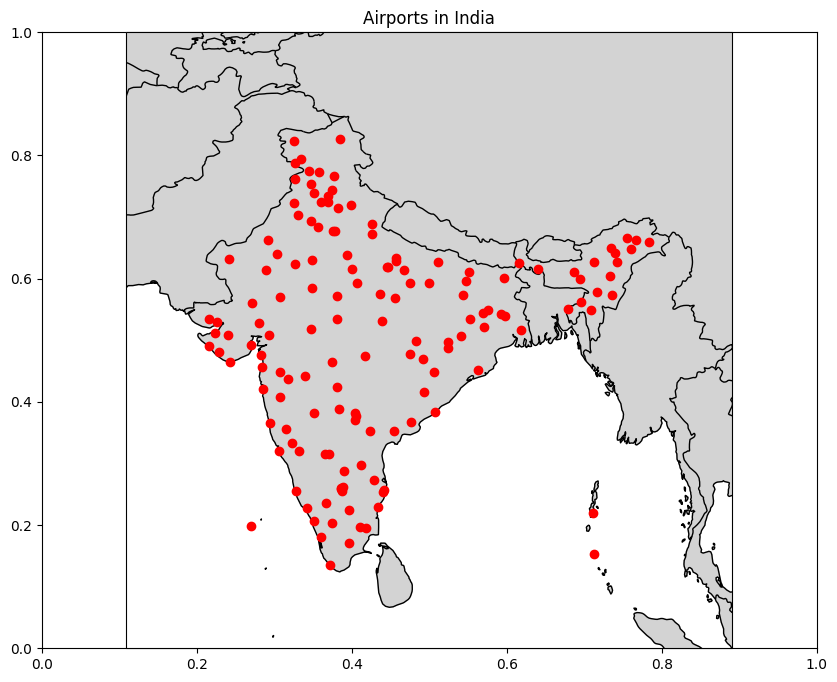

In [3]:
india_env.plot_airports_by_country("India")

From this map we can see there is an almost equal distribution of airports throughout India.

/Users/nico/Documents/portfolio/Group_04/Functions/air_traffic_data.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '2' '3' ... '14108' '14109' '14110']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  airports.loc[:, "Airport ID"] = airports["Airport ID"].astype(str)


<Axes: >

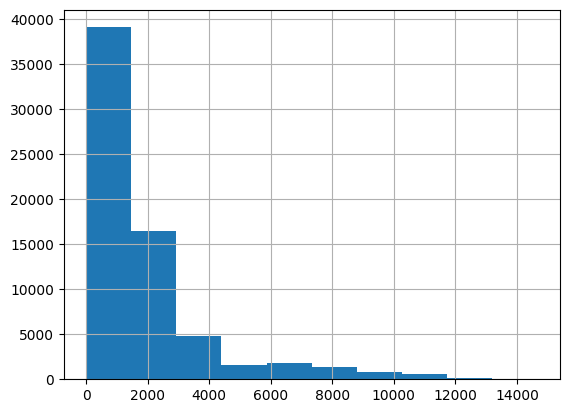

In [4]:
india_env.distance_analysis()

As displayed above, you can tell that half of the covered flights in the world are for routes under 2000 km. This brings to light the great potential there could be in creating a better transportation infrastructure to reduce short-haul flights and increase other, more sustainable methods of transport like trains.

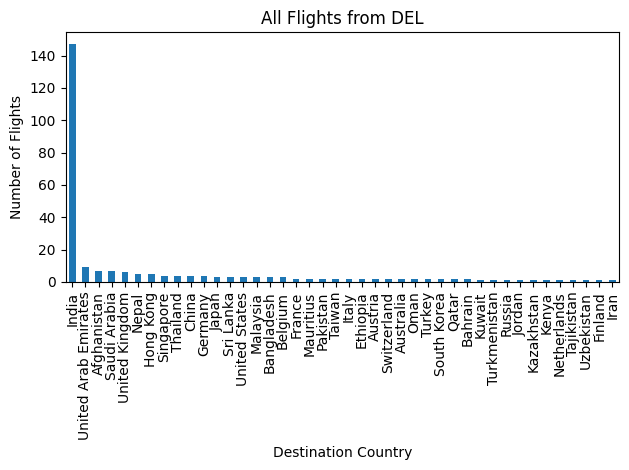

In [5]:
india_env.flights_from_airport("DEL")

As imagined, the great majority of flights departing from Delhi Airport are within India, this could reflect the poor transport infrastracture (e.g. lack of trains).

The second highest destination is UAE and the third is Afghanistan.

In [6]:
india_env.most_used_airplane_models(3, country="India")

Name
Canadair Challenger    31
dtype: int64

It's interesting to observe that in all of India, only one airplane model is being used. However, the dataset seems incomplete due to a lot of missing values, especially concerning the "IATA code" values. 

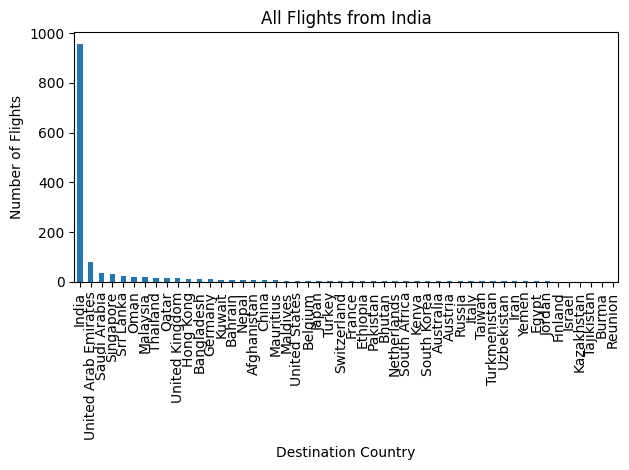

In [7]:
india_env.flights_from_country('India')

As seen before, India mainly has within-country flights, where the second and third most used airports are UAE and Saudi Arabia. This is similar to as observed with Delhi.

In [3]:
AirTrafficData().airport_info('Thule Air Base')

| Aspect             | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| Location           | Located in Pituffik, Greenland                                              |
| Type               | Military air base                                                           |
| Runways            | 1 runway                                                                    |
| Facilities         | Hangars, control tower, barracks, fuel storage                              |
| Services           | Aircraft refueling, maintenance, air traffic control                       |
| Aircraft           | Military aircraft, cargo planes, helicopters                                |
| Security           | Restricted access, security checkpoints, surveillance cameras               |
| Weather            | Cold climate, snow and ice removal equipment                                |
| Communication      | Radio communication, radar systems                                         |
| Emergency          | Fire department, medical facilities, emergency response team                |
| Transportation     | Shuttle service, rental cars, taxi service                                  |
| Amenities          | Dining facilities, lodging, recreation areas                                |
| Environmental      | Waste management, environmental protection measures                        |